In [30]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [31]:
import warnings
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.12.0


In [32]:
# Import necessary libraries
import numpy as np
import pandas as pd
from math import sqrt
from numpy import split, array
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D
from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasRegressor

# Load the file
path = '/content/drive/MyDrive/Time-series_data_pre_procss/Energy_demand_data/pak_load_till_2023.csv'
dataset = pd.read_csv(path, header=0)
#dataset= dataset.iloc[:,:-1]
dataset.dropna()
dataset['datetime'] = pd.to_datetime(dataset[['YEAR', 'MONTH', 'DAY', 'Hour']])
dataset.set_index('datetime', inplace=True)
dataset = dataset.drop(dataset.columns[[0 ,1, 2, 3]], axis=1)
dataset.head()


,Demand
datetime,
2019-07-01 01:00:00,19615.2656
2019-07-01 02:00:00,17842.2494
2019-07-01 03:00:00,17663.2494
2019-07-01 04:00:00,18715.0406
2019-07-01 05:00:00,18839.8286


In [33]:
import numpy as np
def split_hourly_data(hourly_load_data, num_years_train):
    # Define the number of hours in a day and days in a year
    hours_per_day = 24
    days_per_year = 365

    # Calculate the total number of hours in the data
    total_hours = len(hourly_load_data)

    # Calculate the number of hours per year
    hours_per_year = hours_per_day * days_per_year

    # Calculate the number of hours for training
    train_hours = num_years_train * hours_per_year

    # Split the data into train and test sets
    train_data_org = hourly_load_data[:-train_hours]
    test_data_org = hourly_load_data[-train_hours:]
    train_data = array(split(train_data_org, len(train_data_org)/6))
    test_data = array(split(test_data_org, len(test_data_org)/6))
    return train_data, test_data, train_data_org, test_data_org

train_data, test_data, train_data_org, test_data_org = split_hourly_data(dataset,1)
print(train_data.shape)
print(test_data.shape)
print(test_data_org.shape)


(5120, 6, 1)
(1460, 6, 1)
(8760, 1)


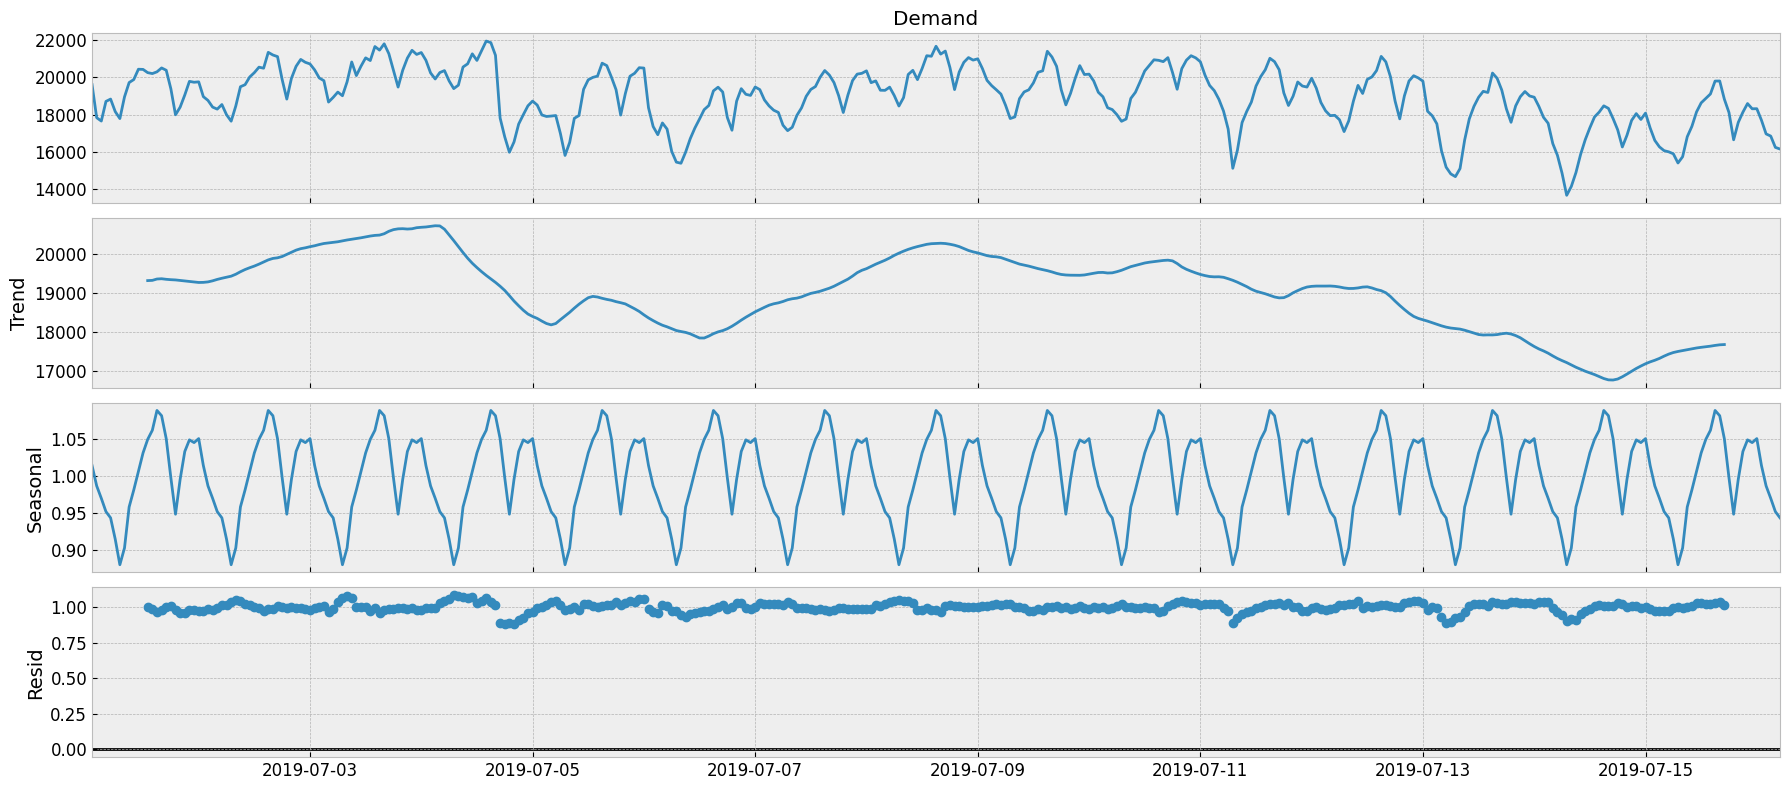

<Figure size 4000x1600 with 0 Axes>

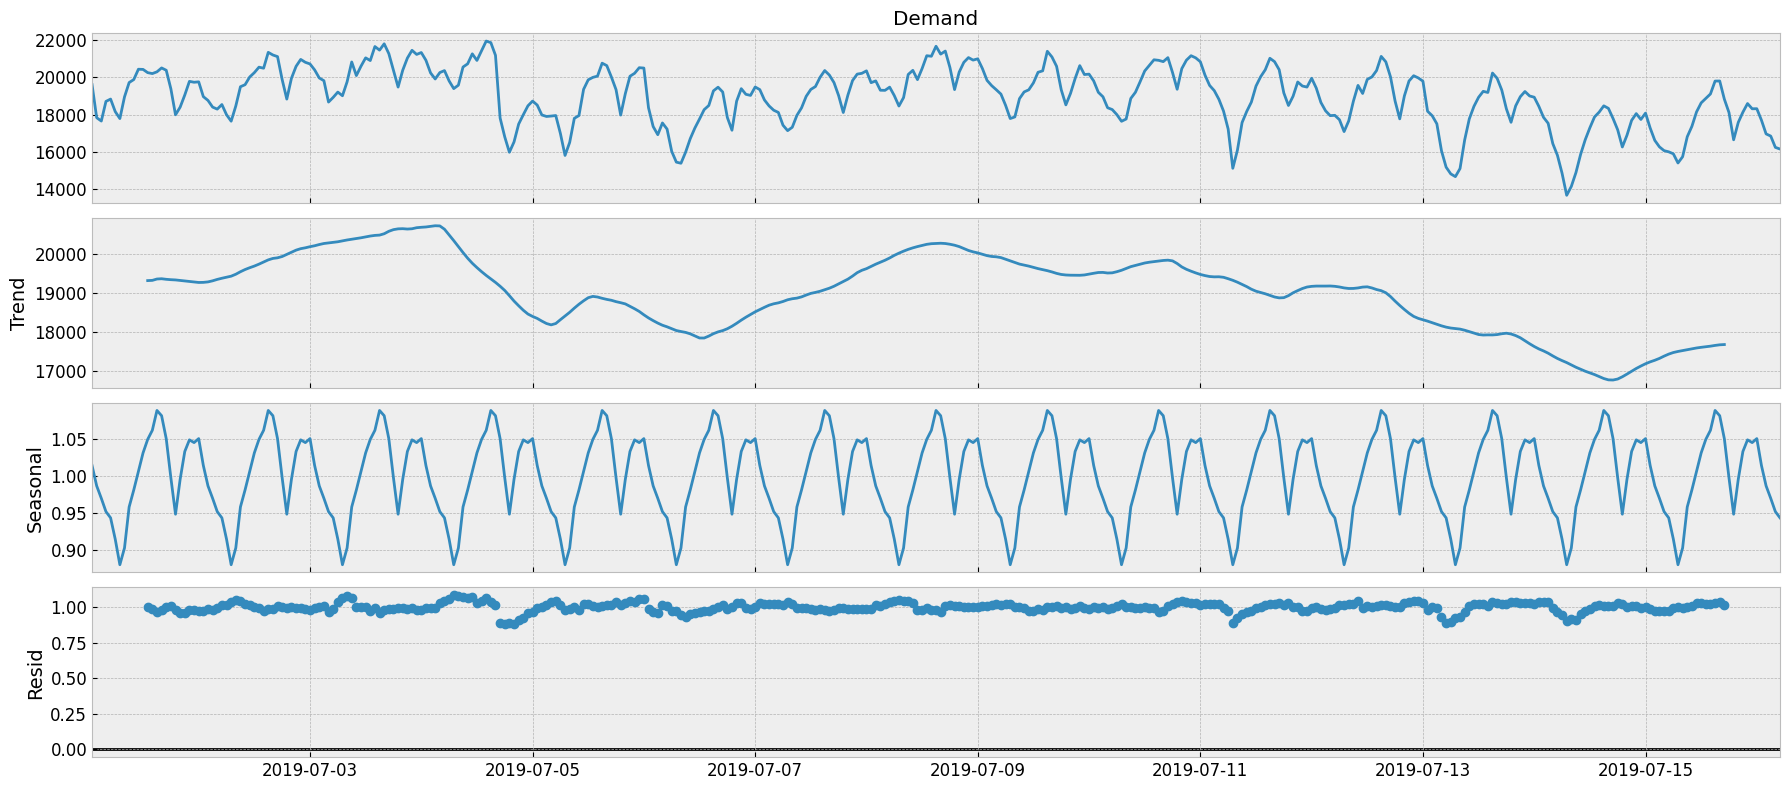

In [34]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = train_data_org.Demand[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

Text(0.5, 1.0, 'Mean over time')

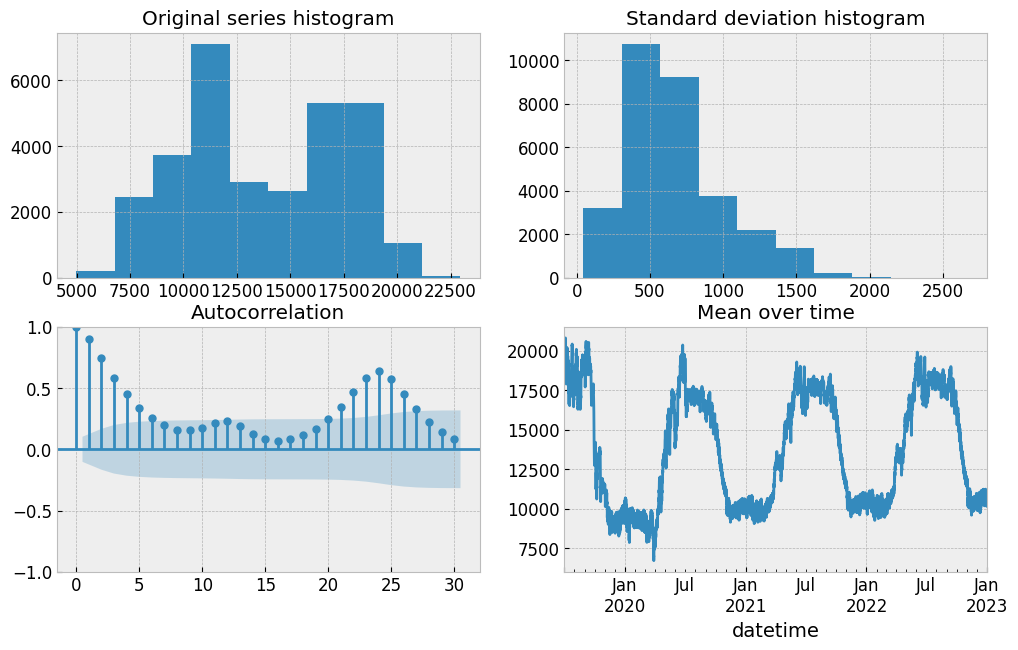

In [35]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

train_data_org.Demand.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = train_data_org.Demand.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = train_data_org.Demand.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

In [36]:
result = adfuller(train_data_org.Demand)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.617652
p-value: 0.089404
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [37]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

ADF Statistic: -27.625506
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistic: -26.842723
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistic: -53.681571
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


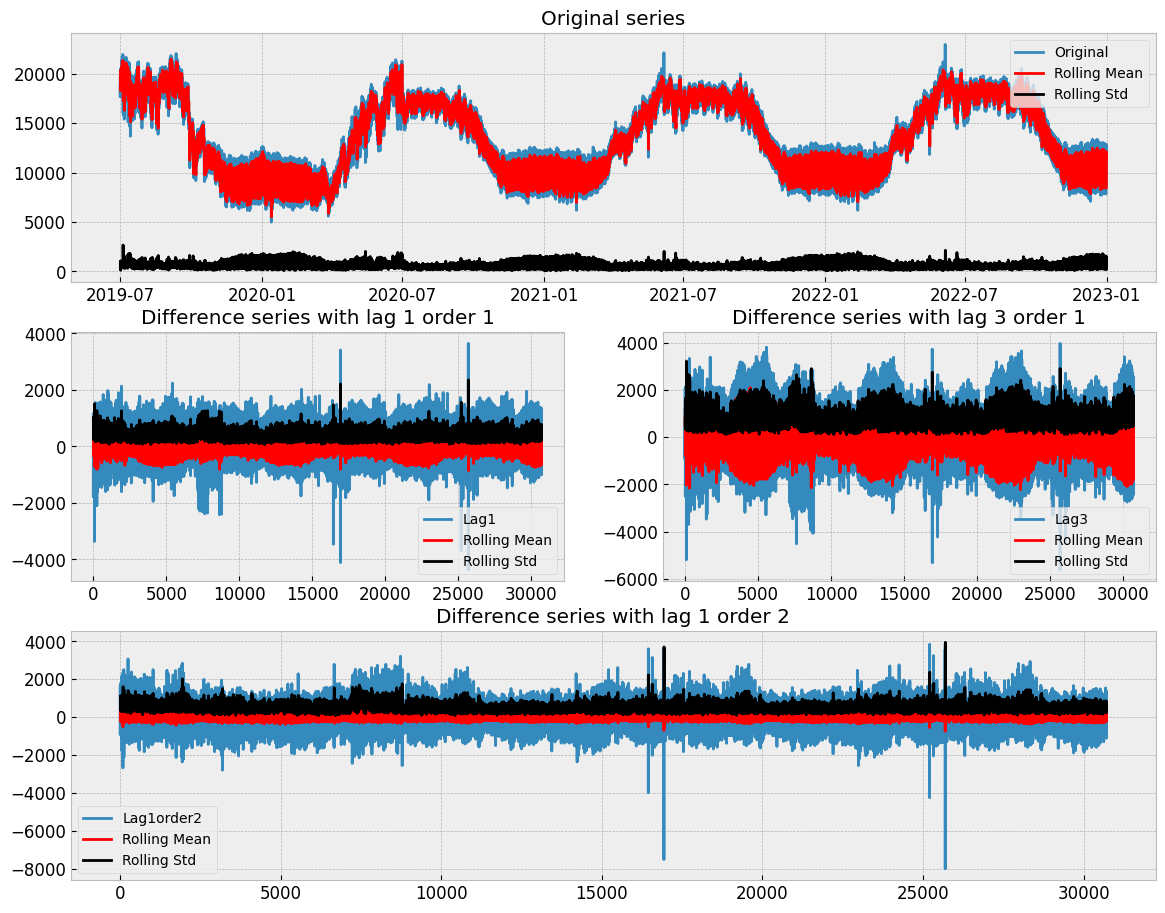

In [38]:
lag1series = pd.Series(difference(train_data_org.Demand, interval=1, order=1))
lag3series = pd.Series(difference(train_data_org.Demand, interval=3, order=1))
lag1order2series = pd.Series(difference(train_data_org.Demand, interval=1, order=2))

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(train_data_org.Demand, label='Original')
original.plot(train_data_org.Demand.rolling(
    7).mean(), color='red', label='Rolling Mean')
original.plot(train_data_org.Demand.rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')

Z = lag1series = pd.Series(difference(train_data_org.Demand, interval=1, order=1))
result = adfuller(Z)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


y = lag3series = pd.Series(difference(train_data_org.Demand, interval=3, order=1))
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


X = lag1order2series = pd.Series(difference(
    train_data_org.Demand, interval=1, order=2))
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


In [39]:
ts_log = np.log(train_data_org.Demand)
# ts_log.plot(label='Log scale result')
# ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
# ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
# plt.legend()
# plt.title('Log scale transformation into original series')

from scipy.stats import boxcox

transformed_data, lambda_value = boxcox(train_data_org.Demand)
result = adfuller(transformed_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

W = ts_log
result = adfuller(W)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.523840
p-value: 0.109781
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistic: -2.373815
p-value: 0.149264
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [40]:
train_data.shape

(5120, 6, 1)

In [41]:
print(pd.Series(difference(train_data_org.Demand, interval=1, order=1)).shape)
print(pd.Series(difference(train_data_org.Demand, interval=3, order=1)).shape)
print(pd.Series(difference(train_data_org.Demand, interval=1, order=2)).shape)
train_data = pd.Series(difference(train_data_org.Demand, interval=1, order=2))


(30719,)
(30717,)
(30718,)


In [42]:
import numpy as np

# Assuming 'train_data' is your data of shape (30719,)
# Replace this with your actual 'train_data'
train_data = train_data
# np.random.rand(30719)
# Define the target shape
target_shape = (5120, 6, 1)

# Calculate the total number of elements in the target shape
target_size = np.prod(target_shape)

# Check if the train_data size is larger than the target size
if train_data.size > target_size:
    # Truncate the train_data to match the target size
    truncated_data = train_data[:target_size]
else:
    # If the train_data is smaller, pad it with zeros
    pad_size = target_size - train_data.size
    truncated_data = np.pad(train_data, (0, pad_size), 'constant')

# Reshape the truncated data to the target shape
reshaped_data = truncated_data.reshape(target_shape)

# Now, 'reshaped_data' has the shape (5120, 6, 1)
print("Reshaped train_data shape:", reshaped_data.shape)


Reshaped train_data shape: (5120, 6, 1)


In [49]:
train_data = reshaped_data
#train_data = train_data.values
train_data.shape

(5120, 6, 1)

In [50]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
    # define the end of the input sequence
      in_end = in_start + n_input
      out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input, output_csv_path):
    # fit model
    model = build_model(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.extend(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = np.array(predictions)
    flat_predictions = predictions.flatten()
    # Save hourly predictions to a CSV file
    predictions_df = pd.DataFrame({'Prediction': flat_predictions})
    predictions_df.to_csv(output_csv_path, index=False)

    return output_csv_path


n_steps, n_length = 6,6
# define the total days to use as input
n_input = n_length * n_steps
# Define the output CSV file path

output_csv_path = '/content/drive/MyDrive/Time-series_data_pre_procss/Energy_demand_data/pak_load_till_2023_output_04.csv'

# Call evaluate_model and save hourly predictions
output_file = evaluate_model(train_data, test_data, n_steps, n_length, n_input, output_csv_path)



In [90]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

path = '/content/drive/MyDrive/Time-series_data_pre_procss/Energy_demand_data/pak_load_till_2023_final_all_combined.csv'
final_pre = pd.read_csv(path)
final_pre['datetime'] = pd.to_datetime(final_pre[['YEAR', 'MONTH', 'DAY', 'Hour']])
final_pre.set_index('datetime', inplace=True)
#final_pre.dropna(inplace=True)  # Drop rows with NaN values and update 'final_pre'
final_pre = final_pre.drop(final_pre.columns[[0, 1, 2, 3,]], axis=1)
#final_pre.tail(10)

year = 2023
# Filter rows where the 'datetime' column corresponds to the specified year
predictions = final_pre[final_pre.index.year == year]  # Use .index.year to filter by year
predictions.head(10)

# Create a dictionary to store RMSE values
rmse_values = {}
# Define the prediction column names
prediction_columns = ['Prediction_01', 'Prediction_02', 'Prediction_03','Prediction_04']
# Remove rows with NaN values in 'Price' or any of the prediction columns
final_pre_cleaned = final_pre.dropna(subset=['Demand'] + prediction_columns)

# Calculate RMSE for each prediction column
for prediction_col in prediction_columns:
    rmse = np.sqrt(mean_squared_error(final_pre_cleaned['Demand'], final_pre_cleaned[prediction_col]))
    rmse_values[prediction_col] = rmse
    print(f'RMSE between Demand and {prediction_col}: {rmse}')

# Find the prediction column with the lowest RMSE
min_rmse_column = min(rmse_values, key=rmse_values.get)
min_rmse_value = rmse_values[min_rmse_column]

print(f'lowest RMSE is {min_rmse_column} with RMSE value: {min_rmse_value}')



RMSE between Demand and Prediction_01: 10655.396290368855
RMSE between Demand and Prediction_02: 13843.2693297541
RMSE between Demand and Prediction_03: 14018.33454184714
RMSE between Demand and Prediction_04: 14643.79911297941
lowest RMSE is Prediction_01 with RMSE value: 10655.396290368855
